# Example of Taylor series expansion of kinetic and potential energy operators for ammonia

Here, we use the following internal coordinates of ammonia molecule $\text{NH}_3$

1. $r_1$
2. $r_2$
3. $r_3$
4. $s_4 = (2\alpha_{23}-\alpha_{13}-\alpha_{12})/\sqrt{6}$
5. $s_5 = (\alpha_{13}-\alpha_{12})/\sqrt{2}$
6. $\rho$

where $r_i\equiv\text{N-H}_i$, $\alpha_{ij}\equiv\text{H}_i\text{-C-H}_j$, and $\rho$ is an 'umbrella' angle $[0,\pi]$.

We will build expansion of the potential energy surface (PES) in terms of the following 1D functions of internal coordinates:

- $y_1=1-\exp(-a_m(r_1-r_1^{(eq)}))$
- $y_2=1-\exp(-a_m(r_2-r_2^{(eq)}))$
- $y_3=1-\exp(-a_m(r_3-r_3^{(eq)}))$
- $y_4=s_4$
- $y_5=s_5$
- $y_6=\cos(\rho)$

For expansion of the kinetic energy operator (KEO), we use the following 1D functions of internal coordinates:

- $z_1=r_1-r_1^{(eq)}$
- $z_2=r_2-r_2^{(eq)}$
- $z_3=r_3-r_3^{(eq)}$
- $z_4=s_4$
- $z_5=s_5$
- $z_6=\cos(\rho)$

In [1]:
import itertools
import os

import jax
import matplotlib.pyplot as plt
import numpy as np
from jax import config
from jax import numpy as jnp
from scipy import optimize

from vibrojet.jet_prim import acos
from vibrojet.keo import Gmat, com, pseudo
from vibrojet.potentials import nh3_POK
from vibrojet.taylor import deriv_list

config.update("jax_enable_x64", True)

Define a function `find_alpha_from_s_delta` to obtain three $\alpha_{ij}$ valence angular coordinates from the two symmetrized $s_4$, $s_5$ and 'umbrella' angle $\delta=\rho-\pi/2$ coordinates.

In [2]:
def find_alpha_from_s_delta(s4, s5, delta, no_iter: int = 10):

    sqrt2 = jnp.sqrt(2.0)
    sqrt3 = jnp.sqrt(3.0)
    sqrt6 = jnp.sqrt(6.0)

    def calc_s_to_sin_delta(s6, s4, s5):
        alpha1 = (sqrt2 * s6 + 2 * s4) / sqrt6
        alpha2 = (sqrt2 * s6 - s4 + sqrt3 * s5) / sqrt6
        alpha3 = (sqrt2 * s6 - s4 - sqrt3 * s5) / sqrt6
        cos_alpha1 = jnp.cos(alpha1)
        cos_alpha2 = jnp.cos(alpha2)
        cos_alpha3 = jnp.cos(alpha3)
        sin_alpha1 = jnp.sin(alpha1)
        sin_alpha2 = jnp.sin(alpha2)
        sin_alpha3 = jnp.sin(alpha3)
        tau_2 = (
            1
            - cos_alpha1**2
            - cos_alpha2**2
            - cos_alpha3**2
            + 2 * cos_alpha1 * cos_alpha2 * cos_alpha3
        )
        norm_2 = (
            sin_alpha3**2
            + sin_alpha2**2
            + sin_alpha1**2
            + 2 * cos_alpha3 * cos_alpha1
            - 2 * cos_alpha2
            + 2 * cos_alpha2 * cos_alpha3
            - 2 * cos_alpha1
            + 2 * cos_alpha2 * cos_alpha1
            - 2 * cos_alpha3
        )
        return tau_2 / norm_2

    # initial value for s6
    alpha1 = 2 * jnp.pi / 3
    s6 = alpha1 * sqrt3
    sin_delta = jnp.sin(delta)
    sin_delta2 = sin_delta**2

    for _ in range(no_iter):
        f = calc_s_to_sin_delta(s6, s4, s5)
        eps = f - sin_delta2
        grad = jax.grad(calc_s_to_sin_delta)(s6, s4, s5)
        dx = eps / grad
        dx0 = dx
        s6 = s6 - dx0

    alpha1 = (sqrt2 * s6 + 2 * s4) / sqrt6
    alpha2 = (sqrt2 * s6 - s4 + sqrt3 * s5) / sqrt6
    alpha3 = (sqrt2 * s6 - s4 - sqrt3 * s5) / sqrt6

    return alpha1, alpha2, alpha3

Find equilibrium values of internal coordinates

In [3]:
@jax.jit
def poten(q):
    r1, r2, r3, s4, s5, rho = q
    delta = rho - jnp.pi / 2
    alpha1, alpha2, alpha3 = find_alpha_from_s_delta(s4, s5, delta)
    v = nh3_POK.poten((r1, r2, r3, alpha1, alpha2, alpha3))
    return v

vmin = optimize.minimize(poten, [1.1, 1.1, 1.1, 0.5, 0.5, np.pi/2])
q0 = vmin.x
v0 = vmin.fun
print("equilibrium coordinates:", q0)
print("min of the potential:", v0)

equilibrium coordinates: [ 1.01159999e+00  1.01159999e+00  1.01159999e+00 -7.40384010e-09
 -7.51104812e-09  1.95651869e+00]
min of the potential: 4.175203295455632e-11


Define mapping from internal coordinates to Cartesian coordinates, to $y$-coordinates used for expansion of PES, and $z$-coordinates used for expansion of KEO.

In [14]:
# masses of N, H1, H2, H3
masses = [14.00307400, 1.007825035, 1.007825035, 1.007825035]


# internal-to-Cartesian coordinate transformation


@com(masses)
def internal_to_cartesian(internal_coords):
    r1, r2, r3, s4, s5, rho = internal_coords
    delta = rho - jnp.pi / 2
    alpha1, alpha2, alpha3 = find_alpha_from_s_delta(s4, s5, delta)

    cos_rho = jnp.cos(rho)
    sin_rho = jnp.sin(rho)

    # beta3 = acos((jnp.cos(alpha3) - jnp.cos(rho) ** 2) / jnp.sin(rho) ** 2)
    # beta2 = acos((jnp.cos(alpha2) - jnp.cos(rho) ** 2) / jnp.sin(rho) ** 2)

    cos_beta3 = (jnp.cos(alpha3) - cos_rho**2) / sin_rho**2
    cos_beta2 = (jnp.cos(alpha2) - cos_rho**2) / sin_rho**2

    sin_beta3 = jnp.sin(acos(cos_beta3))
    sin_beta2 = jnp.sin(acos(cos_beta2))

    # sin_beta3 = jnp.sqrt(1 - cos_beta3**2)  # 0 < beta3 < pi
    # sin_beta2 = jnp.sqrt(1 - cos_beta2**2)  # 0 < beta2 < pi

    xyz = jnp.array(
        [
            [0.0, 0.0, 0.0],
            [r1 * sin_rho, 0.0, r1 * cos_rho],
            [r2 * sin_rho * cos_beta3, r2 * sin_rho * sin_beta3, r2 * cos_rho],
            [r3 * sin_rho * cos_beta2, -r3 * sin_rho * sin_beta2, r3 * cos_rho],
        ]
    )
    return xyz


# y-coordinates for expansion of PES

# Morse constant necessary for defining y-coordinates for stretches
a_morse = 2.0


def internal_to_y(q):
    r1, r2, r3, s4, s5, rho = q
    y1 = 1 - jnp.exp(-a_morse * (r1 - q0[0]))
    y2 = 1 - jnp.exp(-a_morse * (r2 - q0[1]))
    y3 = 1 - jnp.exp(-a_morse * (r3 - q0[2]))
    y4 = s4
    y5 = s5
    y6 = jnp.sin(rho)
    return jnp.array([y1, y2, y3, y4, y5, y6])


def y_to_internal(y):
    y1, y2, y3, y4, y5, y6 = y
    r1 = -jnp.log(1 - y1) / a_morse + q0[0]
    r2 = -jnp.log(1 - y2) / a_morse + q0[1]
    r3 = -jnp.log(1 - y3) / a_morse + q0[2]
    s4 = y4
    s5 = y5
    rho = np.pi / 2 - acos(y6)  # asin(y6)
    return jnp.array([r1, r2, r3, s4, s5, rho])


y0 = internal_to_y(q0)


# z-coordinates for expansion of KEO


def internal_to_z(q):
    r1, r2, r3, s4, s5, rho = q
    z1 = r1 - q0[0]
    z2 = r2 - q0[1]
    z3 = r3 - q0[2]
    z4 = s4
    z5 = s5
    z6 = jnp.sin(rho)
    return jnp.array([z1, z2, z3, z4, z5, z6])


def z_to_internal(z):
    z1, z2, z3, z4, z5, z6 = z
    r1 = z1 + q0[0]
    r2 = z2 + q0[1]
    r3 = z3 + q0[2]
    s4 = z4
    s5 = z5
    rho = np.pi / 2 - acos(z6)  # asin(z6)
    return jnp.array([r1, r2, r3, s4, s5, rho])


z0 = internal_to_z(q0)

In [15]:
xyz = internal_to_cartesian(q0)
print("Reference values of internal coordinates:\n", q0)
print("Reference values of expansion y-coordinates:\n", y0)
print("Reference values of expansion z-coordinates:\n", z0)
print("Reference values of Cartesian coordinates:\n", xyz)

Reference values of internal coordinates:
 [ 1.01159999e+00  1.01159999e+00  1.01159999e+00 -7.40384010e-09
 -7.51104812e-09  1.95651869e+00]
Reference values of expansion y-coordinates:
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.40384010e-09
 -7.51104812e-09  9.26526900e-01]
Reference values of expansion z-coordinates:
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.40384010e-09
 -7.51104812e-09  9.26526900e-01]
Reference values of Cartesian coordinates:
 [[ 3.89532355e-10  3.92221069e-10  6.75834407e-02]
 [ 9.37274605e-01  3.92221069e-10 -3.13009332e-01]
 [-4.68637311e-01  8.11703613e-01 -3.13009332e-01]
 [-4.68637300e-01 -8.11703619e-01 -3.13009332e-01]]


Generate expansion power indices

In [16]:
max_order = 6  # max total expansion order
deriv_ind = [
    elem
    for elem in itertools.product(*[range(0, max_order + 1) for _ in range(len(q0))])
    if sum(elem) <= max_order
]
print("max expansion order:", max_order)
print("number of expansion terms:", len(deriv_ind))

max expansion order: 6
number of expansion terms: 924


Generate expansion of PES in terms of internal coordinates

In [17]:
@jax.jit
def poten(q):
    r1, r2, r3, s4, s5, rho = q
    delta = rho - jnp.pi / 2
    alpha1, alpha2, alpha3 = find_alpha_from_s_delta(s4, s5, delta)
    v = nh3_POK.poten((r1, r2, r3, alpha1, alpha2, alpha3))
    return v


poten_file = f"nh3_poten_coefs_{max_order}.npy"
if os.path.exists(poten_file):
    print(f"load potential expansion coefs from file {poten_file}")
    poten_coefs = np.load(poten_file)
else:
    poten_coefs = deriv_list(poten, deriv_ind, q0, if_taylor=True)
    np.save(poten_file, poten_coefs)

load potential expansion coefs from file nh3_poten_coefs_6.npy


Generate expansion of PES in terms of $y$-coordinates

In [18]:
@jax.jit
def poten_in_y(y):
    q = y_to_internal(y)
    r1, r2, r3, s4, s5, rho = q
    delta = rho - jnp.pi / 2
    alpha1, alpha2, alpha3 = find_alpha_from_s_delta(s4, s5, delta)
    v = nh3_POK.poten((r1, r2, r3, alpha1, alpha2, alpha3))
    return v


poten_file = f"nh3_poten_in_y_coefs_{max_order}.npy"
if os.path.exists(poten_file):
    print(f"load potential expansion coefs from file {poten_file}")
    poten_in_y_coefs = np.load(poten_file)
else:
    poten_in_y_coefs = deriv_list(poten_in_y, deriv_ind, y0, if_taylor=True)
    np.save(poten_file, poten_in_y_coefs)

load potential expansion coefs from file nh3_poten_in_y_coefs_6.npy


Generate expansion of KEO in terms of internal coordinates

In [9]:
max_order = 4  # max total expansion order
deriv_ind = [
    elem
    for elem in itertools.product(*[range(0, max_order + 1) for _ in range(len(q0))])
    if sum(elem) <= max_order
]
print("max expansion order:", max_order)
print("number of expansion terms:", len(deriv_ind))

gmat_file = f"nh3_gmat_coefs_{max_order}.npy"
if os.path.exists(gmat_file):
    print(f"load G-matrix expansion coefs from file {gmat_file}")
    gmat_coefs = np.load(gmat_file)
else:
    gmat_coefs = deriv_list(
        lambda x: Gmat(x, masses, internal_to_cartesian), deriv_ind, q0, if_taylor=True
    )
    np.save(gmat_file, gmat_coefs)

max expansion order: 4
number of expansion terms: 210
load G-matrix expansion coefs from file nh3_gmat_coefs_4.npy


Generate expansion of KEO in terms of $z$-coordinates

In [ ]:
gmat_file = f"nh3_gmat_in_z_coefs_{max_order}.npy"
if os.path.exists(gmat_file):
    print(f"load G-matrix expansion coefs from file {gmat_file}")
    gmat_in_z_coefs = np.load(gmat_file)
else:
    gmat_in_z_coefs = deriv_list(
        lambda z: Gmat(z_to_internal(z), masses, internal_to_cartesian),
        deriv_ind,
        z0,
        if_taylor=True,
    )
    np.save(gmat_file, gmat_in_z_coefs)

load G-matrix expansion coefs from file nh3_gmat_in_z_coefs_4.npy


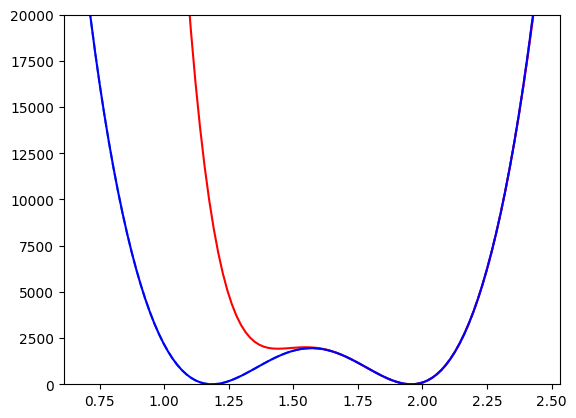

In [12]:
poten_taylor = jax.vmap(
    lambda q: jnp.sum(
        poten_coefs * jnp.prod((q - q0)[None, :] ** jnp.array(deriv_ind), axis=-1)
    ),
    in_axes=0,
)

poten_in_y_taylor = jax.vmap(
    lambda q: jnp.sum(
        poten_in_y_coefs
        * jnp.prod((internal_to_y(q) - y0)[None, :] ** jnp.array(deriv_ind), axis=-1)
    ),
    in_axes=0,
)

rho = np.linspace(40 * np.pi / 180, 140 * np.pi / 180, 100)
q = np.ones((len(rho), 6)) * np.array(q0)[None, :]
q[:, -1] = rho

v0 = jax.vmap(poten, in_axes=0)(q)
v_taylor = poten_taylor(q)
v_in_y_taylor = poten_in_y_taylor(q)

plt.plot(rho, v0, "--")
plt.plot(rho, v_taylor, "r")
plt.plot(rho, v_in_y_taylor, "b")
plt.ylim([0,20000])
plt.show()